In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

import recursive as sv
import pickle
from os import path

In [2]:
data_path = path.join(*(['..']*3+['data','time_series_linear_interpolations']))
path.exists(data_path)

True

In [3]:
with open(path.join(data_path,'olap2.pickle'),'rb') as a:
    svdata = pickle.load(a)

In [4]:
list(svdata.sessions._data[1]._data[1]._data.keys())

['session', 'hr', 'drumming']

In [87]:
svdata.group_id[7]

1009

In [98]:
def get_group_id(svdata, gr_ind):
    return svdata.group_id[gr_ind]

def get_drumming_by_group(svdata,gr_ind):
    sample_drumming=sv.list_store(svdata.sessions.sample(3)).drumming[gr_ind].signal_4hz
    drumming_arr = np.array(sample_drumming.tolist())
    x = drumming_arr[0,0,:]
    y = drumming_arr[:,1,:]
    return x,y

In [5]:
gr_ind = 4
sample_drumming=sv.list_store(svdata.sessions.sample(3)).drumming[gr_ind].signal_4hz

In [6]:
drumming_arr = np.array(sample_drumming.tolist())
drumming_arr.shape

(3, 2, 1560)

In [26]:
x = drumming_arr[0,0,:]
y = drumming_arr[:,1,:]
print(x.shape, y.shape)

(1560,) (3, 1560)


In [31]:
def active_index_range(v1, v2,tol=0.02):
    # find the active time range
    l = v1.size
    start,stop = 0,l
    thres = np.finfo(float).eps #2.220446049250313e-16
    while True:
        w = np.vstack([v1[start:stop],v2[start:stop]])
        m = w.mean()
        new_thres = 0.2*m
        if (new_thres-thres)/thres < tol:
            break
        thres=new_thres
        both_active = (w[0,:]>thres) & (w[1,:]>thres)
        active_ind = np.arange(start,stop)[both_active]
        start = active_ind.min()
        stop = active_ind.max()
    return start, stop, thres

In [9]:
swish = lambda b: lambda x:  x * expit(x-b)
dist = lambda a: lambda x: a*x**2
damp = lambda k: lambda x: 2*expit(k*x)-1


In [10]:
score_func = lambda x: 1-damp(20)(swish(4)(dist(20)(x*2)))

In [39]:
def score_drumming_signals(v1, v2, local=True):
    start, stop, _ = active_index_range(v1,v2)
    width = stop-start
    if width < 200: # 50 seconds
        raise ValueError("Cannot find active range. Found {} {}".format(start, stop))
    s = np.nan*np.ones_like(v1)
    s[start:stop] = score_func((v1-v2)[start:stop])
    if local:
        return s
    return np.nansum(s)/width

def mean_score(v1, v2):
    return score_drumming_signals(v1, v2, False)

In [115]:
def score_drumming_triplets(v, local=True):
    return score_drumming_signals(v.min(axis=0), v.max(axis=0),local)

def mean_score_triplet(v):
    return score_drumming_triplet(v, False)

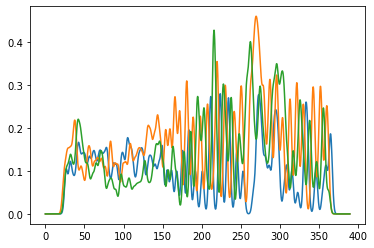

In [35]:
plt.plot(x,y.T)

0.643512745719078

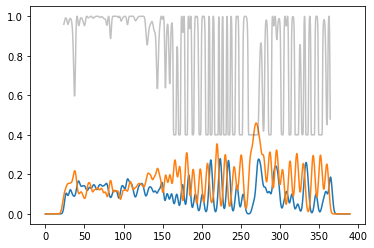

In [47]:
sp = [0,1] # the current signal-pair
plt.plot(x,y.T[:,sp])
plt.plot(x,score_drumming_signals(*y[sp,:])*0.6+0.4,color=(0.2,0.2,0.2,0.3))
mean_score(*y[sp,:])

0.7305187130973081

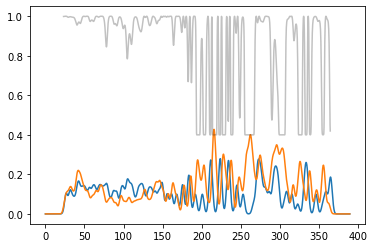

In [48]:
sp = [0,2] # the current signal-pair
plt.plot(x,y.T[:,sp])
plt.plot(x,score_drumming_signals(*y[sp,:])*0.6+0.4,color=(0.2,0.2,0.2,0.3))
mean_score(*y[sp,:])

0.6594963146126265

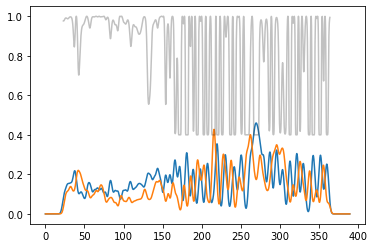

In [49]:
sp = [1,2] # the current signal-pair
plt.plot(x,y.T[:,sp])
plt.plot(x,score_drumming_signals(*y[sp,:])*0.6+0.4,color=(0.2,0.2,0.2,0.3))
mean_score(*y[sp,:])

In [51]:
from itertools import combinations

In [53]:
list(combinations(range(3),2))

[(0, 1), (0, 2), (1, 2)]

In [96]:
def draw_group_pairs(gr_ind):
    combs = [(0, 1), (0, 2), (1, 2)]
    x, y = get_drumming_by_group(svdata,gr_ind)
    if y.shape[0]<3:
        print("This group has only {} drumming signals".format(y.shape[0]))
        return
    fig,axs = plt.subplots(1,3,sharex=True, sharey=True, figsize=(16,4))
    fig.suptitle(f"Group {get_group_id(svdata,gr_ind)} (group score {score_drumming_triplets(y):.3f})")
    for ax,pair in zip(axs,combs):
        y_pair = y[pair,:]
        ax.plot(x,y_pair.T)
        ax.plot(x,score_drumming_signals(*y_pair)*0.6+0.4,color=(0.2,0.2,0.2,0.3))
        ax.plot(x,[0.4]*x.shape[0],'--',color=(0.2,0.2,0.2,0.3))
        #ax.plot(x,score_drumming_signals(*y_pair),color=(0.2,0.2,0.2,0.3))
        ax.set_title("mean_score {:.3f}".format(mean_score(*y_pair)))

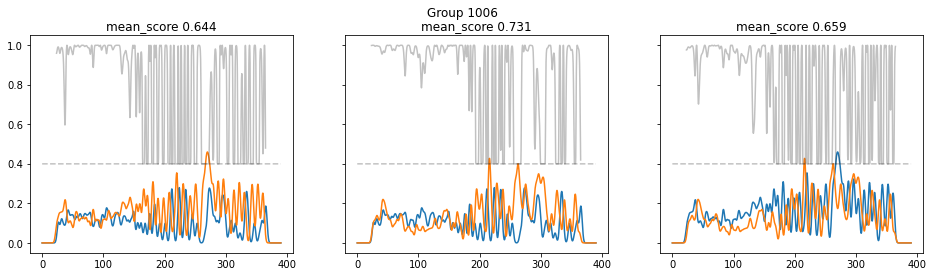

In [99]:
draw_group_pairs(4)

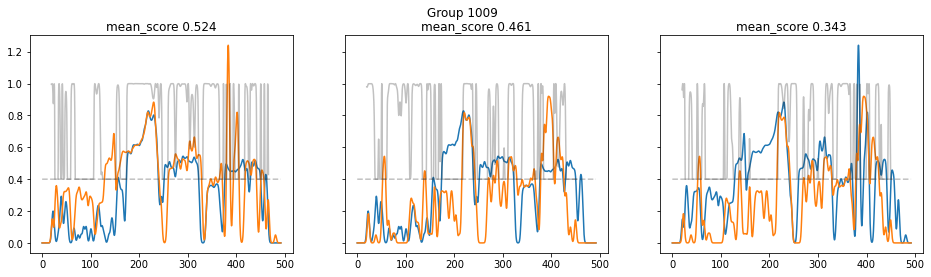

In [100]:
draw_group_pairs(7)

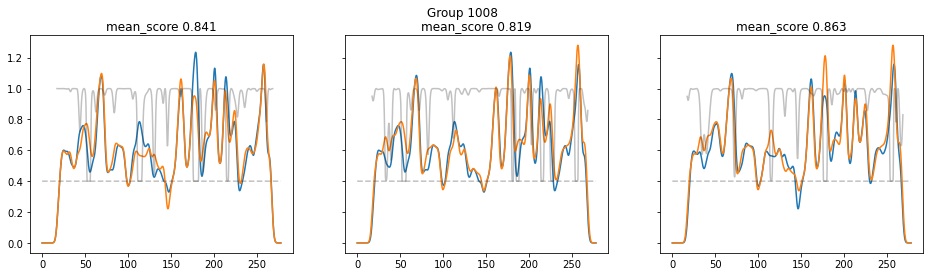

In [101]:
draw_group_pairs(6)

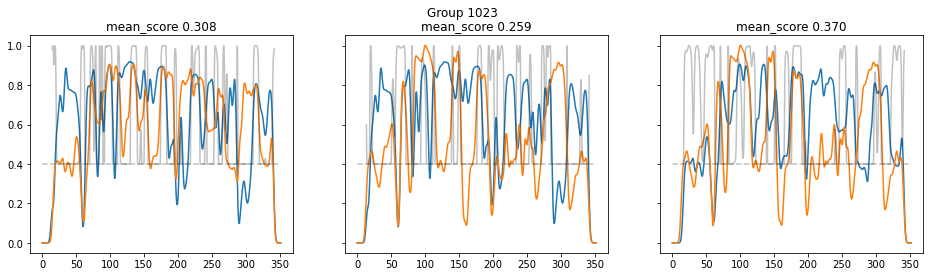

In [102]:
draw_group_pairs(19)

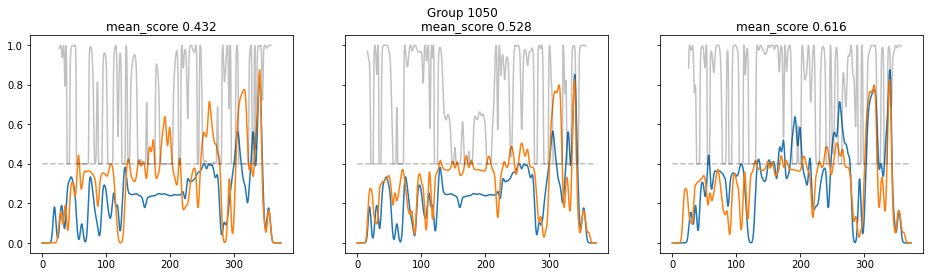

In [107]:
draw_group_pairs(46)

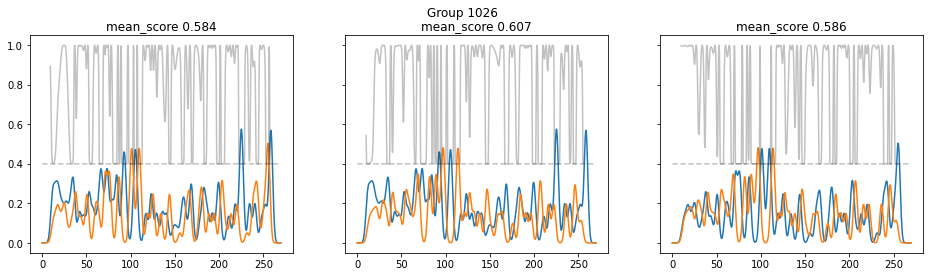

In [110]:
draw_group_pairs(22)

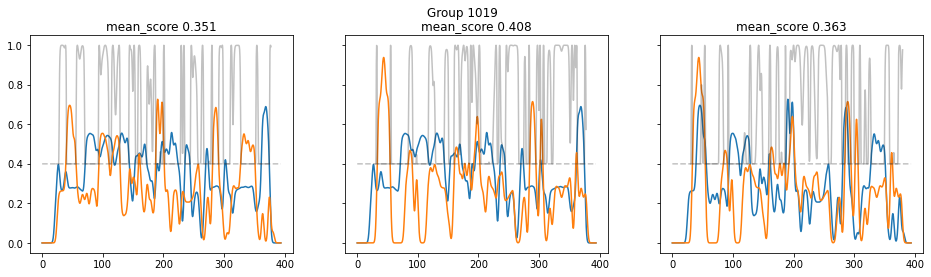

In [114]:
draw_group_pairs(16)